# Machine Learning and Pattern Classification - The haunted turtles
~Noah Pichler, Jacob Harrer, Christopher Schicho, Martin Gegenbauer
## Data Exploration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

cmap = sns.diverging_palette(230, 20, as_cmap=True)

In [2]:
anot = pd.read_pickle("./data/task_2_annotations.pkl")
anot = anot.fillna(anot.median())
anot.head()

,pianist_id,segment_id,annotator_id,arousal,valence,gems_wonder,gems_transcendence,gems_tenderness,gems_nostalgia,gems_peacefulness,gems_power,gems_joyful_activation,gems_tension,gems_sadness,gemmes_flow,gemmes_movement,gemmes_force,gemmes_interior,gemmes_wandering
0,1,0,91,1,-1,2,1,2,4,2.0,1,1,1,2,3,2,1,1.0,2
31,1,0,19,2,-1,3,3,3,4,4.0,1,2,3,3,3,2,2,3.0,3
62,1,0,189,2,0,2,1,2,1,4.0,2,2,1,1,3,2,1,1.0,4
93,1,0,126,2,2,4,5,2,3,5.0,2,4,1,3,5,1,2,2.0,5
124,1,0,26,4,2,3,5,2,3,3.0,1,3,4,1,4,1,2,3.0,1


In [3]:
feat = pd.read_pickle("./data/task_2_features.pkl")
feat.head()

,pianist_id,segment_id,snippet_id,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,...,mirtoolbox_novelty_std,mirtoolbox_novelty_pct_10,mirtoolbox_novelty_pct_50,mirtoolbox_novelty_pct_90,mirtoolbox_pulseclarity,mirtoolbox_roughness_mean,mirtoolbox_roughness_std,mirtoolbox_roughness_pct_10,mirtoolbox_roughness_pct_50,mirtoolbox_roughness_pct_90
0,1,0,0,0.192237,0.059404,2.040252,16079768.0,0.8,0.677256,0.095846,...,0.106446,0.00000,0.013819,0.082176,0.169743,0.011449,0.004161,0.006684,0.011048,0.017025
1,1,0,1,0.143425,0.064204,3.138845,35489248.0,2.6,0.514913,0.092372,...,0.193342,0.00000,0.027786,0.356029,0.355861,0.006205,0.003194,0.002583,0.005657,0.010610
2,1,0,2,0.146967,0.056205,2.019706,42130144.0,2.6,0.560116,0.115359,...,0.218179,0.00000,0.049050,0.375251,0.209162,0.007467,0.003986,0.002330,0.007206,0.012690
3,1,0,3,0.158810,0.059129,3.567908,40922732.0,1.4,0.596779,0.116061,...,0.118148,0.00002,0.017653,0.098657,0.232454,0.007335,0.004063,0.002609,0.006807,0.012971
4,1,0,4,0.168547,0.049648,2.329854,51921612.0,1.6,0.556160,0.143420,...,0.121018,0.00000,0.020525,0.157408,0.140930,0.007345,0.003917,0.002662,0.007016,0.012731


In [4]:
def filter_by_pianist_and_segment(df: pd.DataFrame, pianist_id: int, segment_id: int) -> pd.DataFrame:
    df = df.copy()
    df = df[df["pianist_id"] == pianist_id]
    return df[df["segment_id"] == segment_id]

def get_label(arousal: int, valance: int) -> str:
    if valance > 0 and arousal >= 0:
        return "Happy"
    elif valance <= 0 and arousal > 0:
        return "Angry"
    elif valance < 0 and arousal <= 0:
        return "Sad"
    elif valance >= 0 and arousal < 0:
        return "Relaxed"
    else:
        raise UserWarning("this should not happen")

def create_standardized_label_features(df: pd.DataFrame):
    raw_features = df[["arousal", "valence"]].values
    scaler = StandardScaler()
    scaler.fit(raw_features)
    standardized_features = scaler.transform(raw_features)
    df["arousal_std"] = standardized_features[:,0]
    df["valence_std"] = standardized_features[:,1]

def aggregate_discrete_label(df: pd.DataFrame, use_mean: bool = True) -> pd.DataFrame:
    df = df.copy()
    create_standardized_label_features(df)
    labels = []
    column_names = list(df.columns)
    pianist_col_idx = column_names.index("pianist_id")
    segment_col_idx = column_names.index("segment_id")

    for sample in df.values:
        filtered_df = filter_by_pianist_and_segment(df, sample[pianist_col_idx], sample[segment_col_idx])
        arousal_agg = filtered_df["arousal_std"].mean() if use_mean else filtered_df["arousal_std"].median()
        valance_agg = filtered_df["valence_std"].mean() if use_mean else filtered_df["valence_std"].median()
        labels.append(get_label(arousal_agg, valance_agg))

    df["label"] = labels
    return df

anot = aggregate_discrete_label(anot, use_mean=False)

In [5]:
labels = list(anot["label"].unique())
labels.sort()
labels.insert(2, labels.pop())
labels

['Angry', 'Happy', 'Sad', 'Relaxed']

In [6]:
#distribution
n_samples = len(anot.values)
distribution = dict()
for label in list(anot["label"].unique()):
    distribution[label] = len(anot[anot["label"] == label].values) / n_samples

distribution

{'Angry': 0.4495830174374526,
 'Happy': 0.17475360121304018,
 'Relaxed': 0.13684609552691432,
 'Sad': 0.23881728582259287}

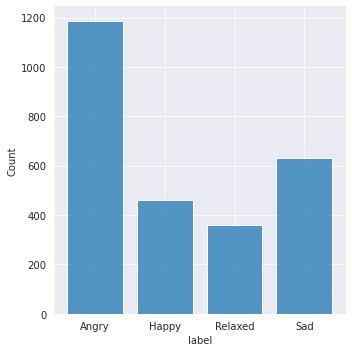

In [7]:
sns.displot(data=anot, x="label", shrink=.8)

In [8]:
def get_bubble_in_quadrant(bubble: np.ndarray, label: str) -> bool:
    in_quadrant = False
    arousal = bubble[0]
    valence = bubble[1]

    if label == "Angry":
        if arousal >= 3 and valence <= 0:
            in_quadrant = True

    elif label == "Happy":
        if arousal >= 3 and valence >= 0:
            in_quadrant = True

    elif label == "Sad":
        if arousal <= 3 and valence <= 0:
            in_quadrant = True

    elif label == "Relaxed":
        if arousal <= 3 and valence >= 0:
            in_quadrant = True

    else:
        raise UserWarning("this should not happen")

    return in_quadrant

def get_bubble_plot_df(df: pd.DataFrame, label: str) -> pd.DataFrame:
    df = df.copy()
    filtered_df = df[df["label"] == label]
    bubble_df = filtered_df.groupby(["arousal", "valence"])\
        .size()\
        .reset_index()\
        .rename(columns={0:"count"})
    bubble_df["in_quadrant"] = [get_bubble_in_quadrant(bubble, label) for bubble in bubble_df.values]
    return bubble_df

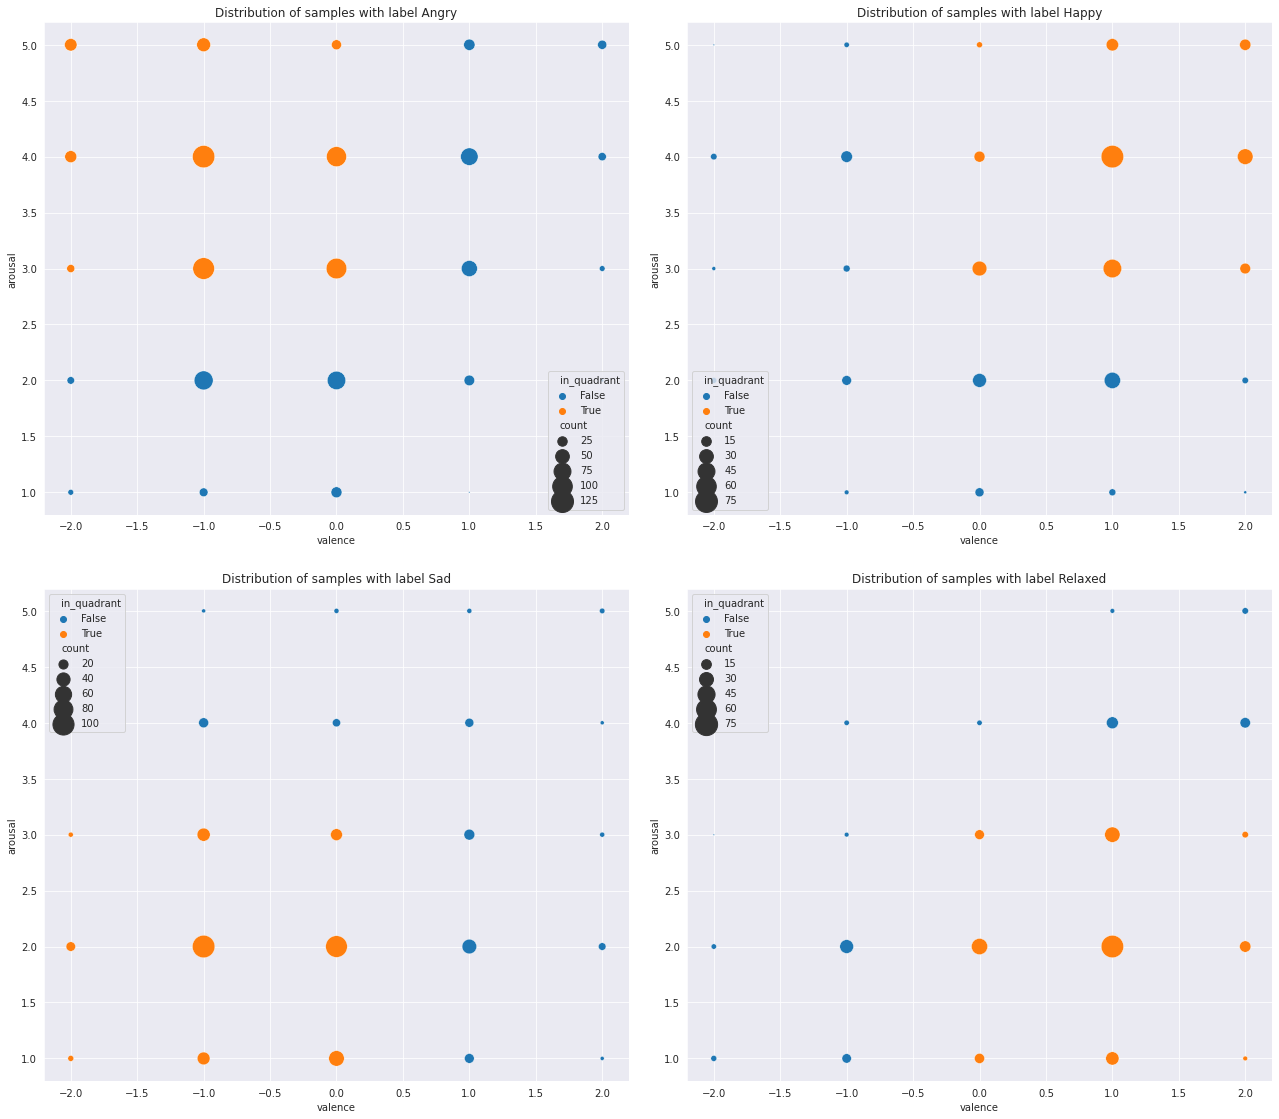

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(22, 15))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.15, wspace=0.1)
for i, label in enumerate(labels):
    row = 0 if i < 2 else 1
    col = i % 2
    bubble_df = get_bubble_plot_df(anot, label)
    axs[row, col].set_title(f"Distribution of samples with label {label}")
    sns.scatterplot(data=bubble_df, x="valence", y="arousal", size="count", hue="in_quadrant", sizes=(2, 500), ax=axs[row, col])

In the plots above we can see, that the annotations are not that consistent and thus, each class is kinda spread with the bigger gathering in the corresponding quadrant.

In [10]:
feature_cols = list(anot.columns)[3:][:-3]
all_feature_df = anot.loc[:, feature_cols]

<AxesSubplot:title={'center':'Distribution of features over all samples'}>

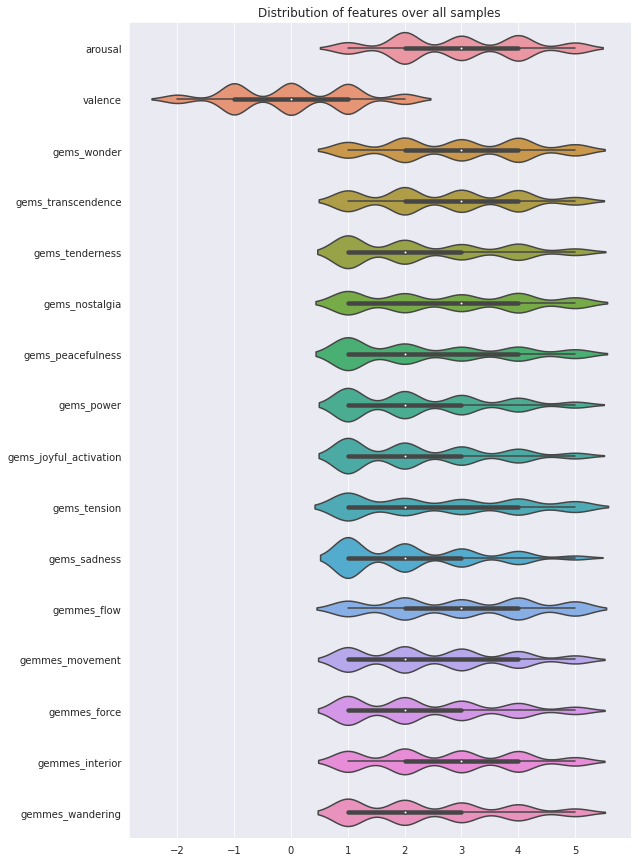

In [11]:
plt.figure(figsize=(9,15))
plt.title("Distribution of features over all samples")
sns.violinplot(data=all_feature_df, orient='h')

<AxesSubplot:title={'center':'Correlations over all samples'}>

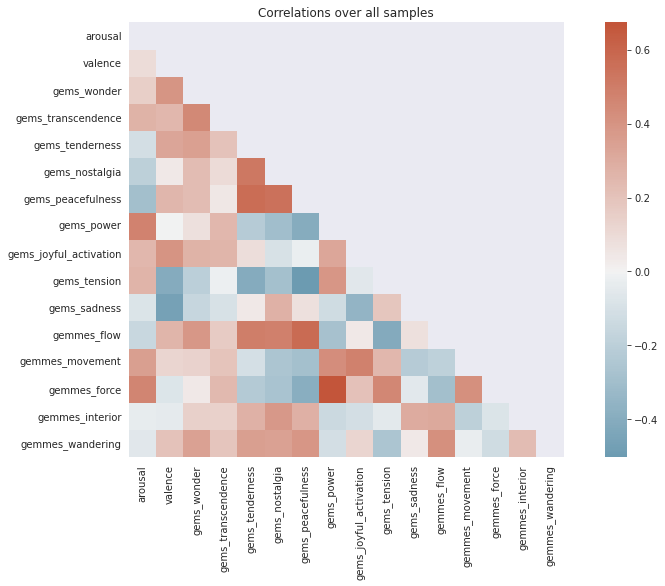

In [12]:
corr_df = all_feature_df.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
plt.figure(figsize=(15,8))
plt.title("Correlations over all samples")
sns.heatmap(corr_df, mask=mask, cmap=cmap, square=True, center=0)

**Features which are positive correlated:**
- arousal ~ gemmes force
- arousal ~ gemmes power
- gemmes tenderness ~ gems peacefulness
- gemmes tenderness ~ gems nostalgia
- gems peacefulness ~ gemmes flow
- gems power ~ gemmes force

**Features which are negative correlated:**
- valence ~ gems sadness
- gems peacefulness ~ gems tension
- gems peacefulness ~ gems power
- gems tension ~ gems flow

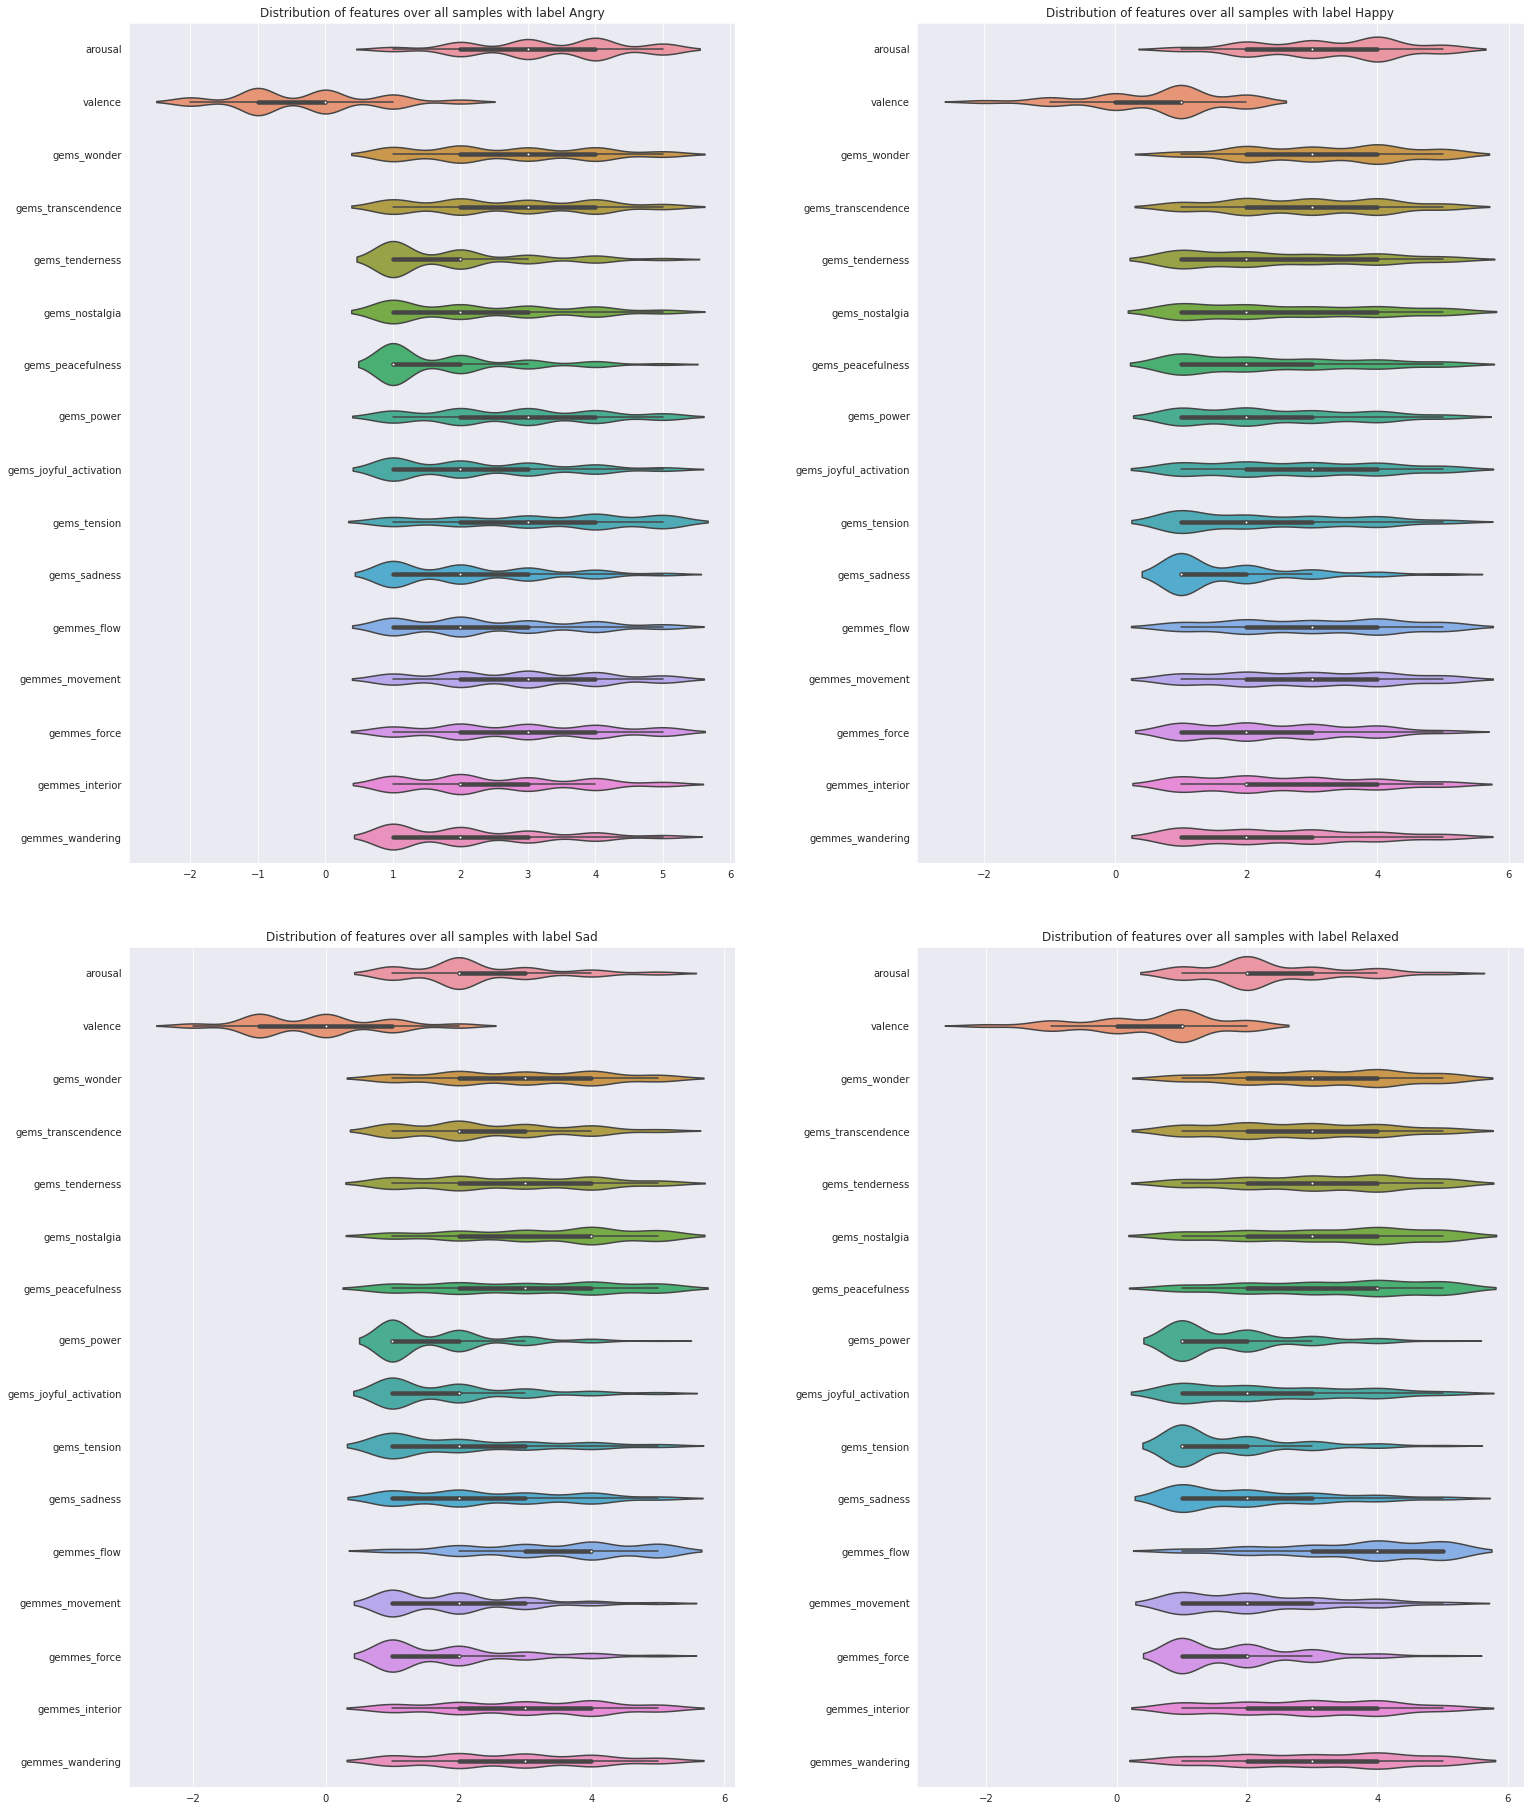

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(25, 25))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.1, wspace=0.3)
for i, label in enumerate(labels):
    row = 0 if i < 2 else 1
    col = i % 2
    filtered_df = anot[anot["label"] == label]
    label_feature_df = filtered_df.loc[:, feature_cols]
    axs[row, col].set_title(f"Distribution of features over all samples with label {label}")
    sns.violinplot(data=label_feature_df, orient='h', ax=axs[row, col])

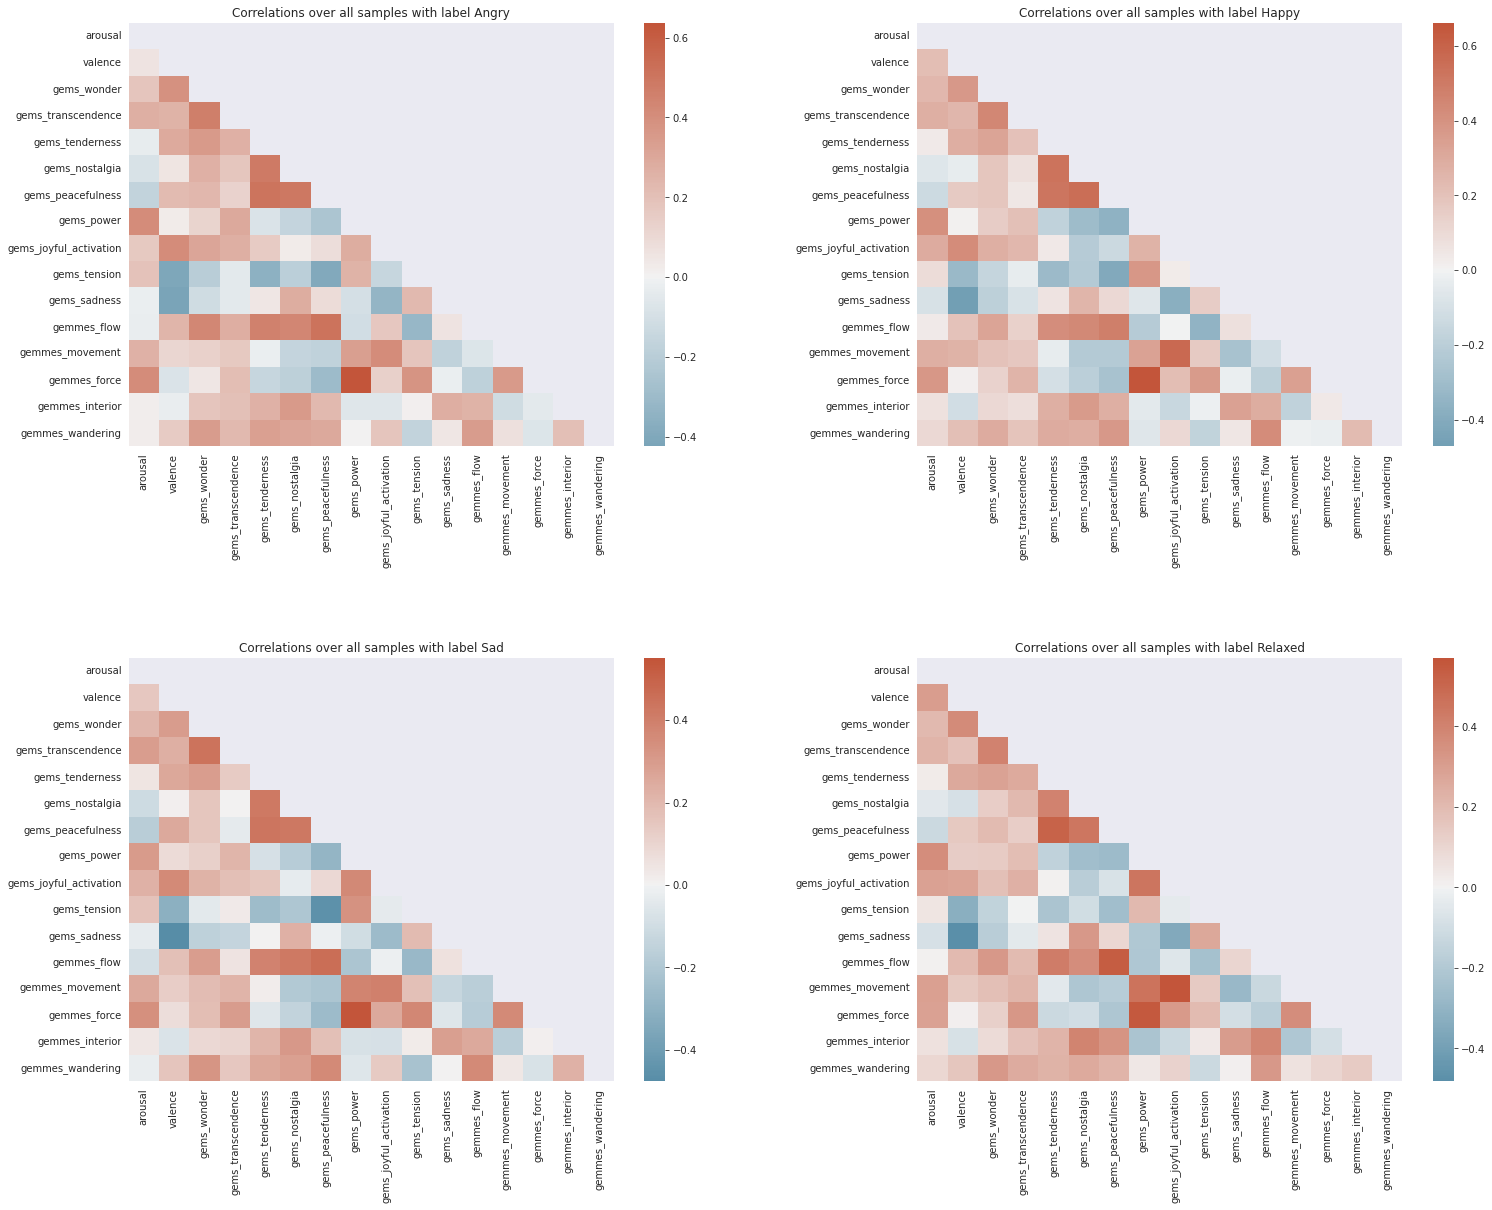

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(25, 15))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.3)
for i, label in enumerate(labels):
    row = 0 if i < 2 else 1
    col = i % 2
    filtered_df = anot[anot["label"] == label]
    label_feature_df = filtered_df.loc[:, feature_cols]
    corr_df = label_feature_df.corr()
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    axs[row, col].set_title(f"Correlations over all samples with label {label}")
    sns.heatmap(corr_df, mask=mask, cmap=cmap, center=0, ax=axs[row, col])

# FOR SLIDES ONLY

<AxesSubplot:title={'center':'Correlations over all samples'}>

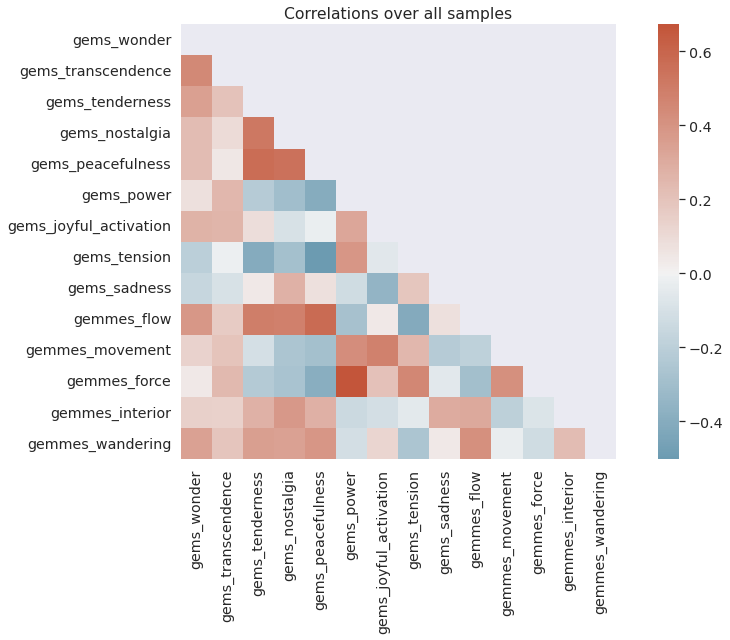

In [18]:
feature_cols = list(anot.columns)[3:][:-3]
feature_cols = feature_cols[2:]
all_feature_df = anot.loc[:, feature_cols]
corr_df = all_feature_df.corr()
sns.set(font_scale = 1.3)
mask = np.triu(np.ones_like(corr_df, dtype=bool))
plt.figure(figsize=(15,8))
plt.title("Correlations over all samples")
sns.heatmap(corr_df, mask=mask, cmap=cmap, square=True, center=0)

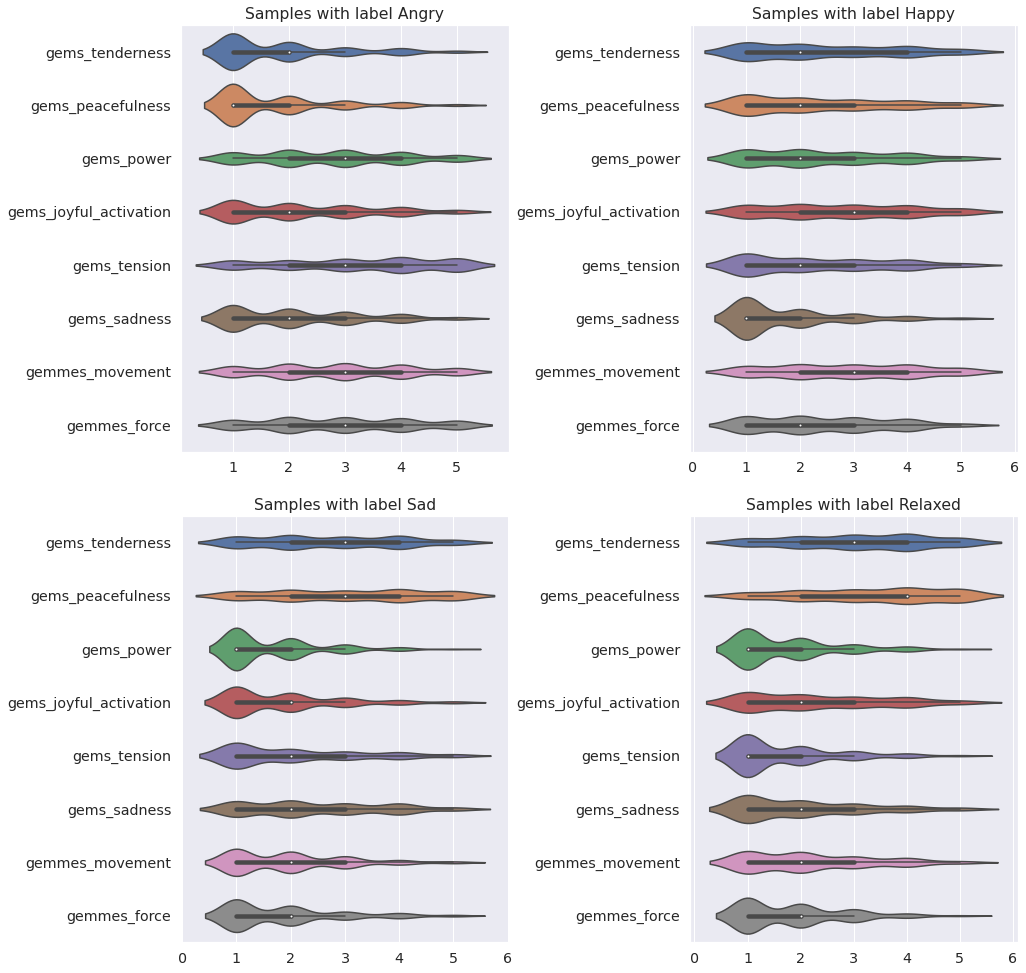

In [19]:
feature_cols = list(anot.columns)[3:][:-5]
feature_cols = [feature_cols[4]] + feature_cols[6:11] + feature_cols[-2:]
all_feature_df = anot.loc[:, feature_cols]
sns.set(font_scale = 1.3)
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.15, wspace=0.55)
for i, label in enumerate(labels):
    row = 0 if i < 2 else 1
    col = i % 2
    filtered_df = anot[anot["label"] == label]
    label_feature_df = filtered_df.loc[:, feature_cols]
    axs[row, col].set_title(f"Samples with label {label}")
    sns.violinplot(data=label_feature_df, orient='h', ax=axs[row, col])